# **Lab 4: Aequitas, Intersectionality, and The Fairness Tree**

In this lab, we will explore [**Aequitas**](http://www.datasciencepublicpolicy.org/our-work/tools-guides/aequitas/), a different python library for discovering fairness concerns in data. Unlike fairLearn, Aequitas does NOT have any mitigation tools, like the `CorrelationRemover` from last week. It only detects bias. However, it gives great plots out of the box!


Unlike previous labs, we will also explore **Intersectionality**, or how bias for *Black Women* can be significantly worse than bias towards *Black people* and the bias towards *Women*. You will have to write the code to produce these plots.

Lastly, we will explore **The Fairness Tree**, a flow chart created by the [Data Science and Public Policy Lab at CMU](http://www.datasciencepublicpolicy.org/) to help find some fairness measures that can be relevant in your upcomming fair machine learning problems, though you will have to think about the stakeholders on your own still.

---

*Official publication on the Aequitas toolkit: https://arxiv.org/pdf/1811.05577.pdf. The concents of this tutorial are based on the offical Aequitas tutorial, which can be found here: https://dssg.github.io/aequitas/examples/compas_demo.html*

#0. Install Libraries

In [ ]:
# %%capture
#@markdown
!pip install aequitas
!pip install folktables
!git clone https://github.com/lurosenb/superquail

zsh:1: command not found: pip
zsh:1: command not found: pip
Cloning into 'superquail'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.(24/24)
remote: Compressing objects: 100% (20/20), done.
remote: Total 24 (delta 1), reused 20 (delta 1), pack-reused 0
Receiving objects: 100% (24/24), 11.90 KiB | 1.98 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
#@title
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from folktables import ACSDataSource, ACSEmployment, ACSIncome, ACSPublicCoverage, ACSMobility, ACSTravelTime
from sklearn.preprocessing import StandardScaler
import seaborn as sns

import matplotlib.pyplot as plt
from IPython.display import clear_output

from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot

#1. Load data

We begin by loading our data. Like before, this data is from the American Community Survey (also called "[Folktables](https://github.com/socialfoundations/folktables)"), and contains individual-level data related to income, employment, health, transportation, and housing. The data has millions of records total, and sensitive attributes include race and sex. It includes 5 separate pre-defined prediction tasks. Today, we will be using data from New York in 2018.

For this lab, we will predict if someone is employed (`ESR`). It's less obvious why people care about this task, but for instance consider:
- A dating app is trying to match people up, and not everyone lists their job. Many people prefer to look for an employed partner the, so wants to secretly infer who is and isn't employed, and use this to match people up.
- This dating app does not want to label people as employed based on their race and sex.

For simplicity, we will also aggregate `RAC1P` down from 8 categories to just 4: people who are only White, only Black, only Asian, and everyone else.

---

**Age:** This dataset will only have people between the ages of 16 and 90.


**Race versus Ethnicity**: in Folktables, ethnicity is a seperate feature from race. So looking at *only the race feature* might hide important traits about people (for example, dataset may identify someone as `race=White` and `ethnicity=Latinx/Hispanic`). Today, we will only use the race feature (`RAC1P`), and we will not use ethnicity (`HISP`). So, this lab is for education purposes, and does not fully illustrate the issues of intersectionality.

For more information about the Folktables features, see page 31 here: https://eaamo2021.eaamo.org/accepted/acceptednonarchival/EAMO21_paper_16.pdf

In [ ]:
#@markdown Import Data. The code is slightly different from before since we are picking data from NY specifically.
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["NY"], download=True)


In [ ]:
#@title
features, labels, group = ACSEmployment.df_to_numpy(acs_data)
feature_names = ACSEmployment.features
data = pd.DataFrame(features, columns = feature_names)
data.head()

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P
0,26.0,21.0,5.0,17.0,2.0,0.0,5.0,1.0,4.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0
1,21.0,20.0,5.0,17.0,2.0,0.0,1.0,3.0,4.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0
2,18.0,16.0,5.0,17.0,2.0,0.0,2.0,3.0,4.0,1.0,1.0,2.0,2.0,2.0,2.0,8.0
3,85.0,16.0,2.0,16.0,1.0,0.0,1.0,1.0,4.0,4.0,1.0,1.0,2.0,1.0,2.0,1.0
4,19.0,19.0,5.0,17.0,2.0,0.0,1.0,1.0,4.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0


In [ ]:
#@markdown Drop rows with missing values
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196967 entries, 0 to 196966
Data columns (total 16 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   AGEP      196967 non-null  float64
 1   SCHL      196967 non-null  float64
 2   MAR       196967 non-null  float64
 3   RELP      196967 non-null  float64
 4   DIS       196967 non-null  float64
 5   ESP       196967 non-null  float64
 6   CIT       196967 non-null  float64
 7   MIG       196967 non-null  float64
 8   MIL       196967 non-null  float64
 9   ANC       196967 non-null  float64
 10  NATIVITY  196967 non-null  float64
 11  DEAR      196967 non-null  float64
 12  DEYE      196967 non-null  float64
 13  DREM      196967 non-null  float64
 14  SEX       196967 non-null  float64
 15  RAC1P     196967 non-null  float64
dtypes: float64(16)
memory usage: 24.0 MB


In [ ]:
#@markdown We aggregate race to four groups and make text labels for race and sex.

# Meaning of the aggregated race categories
race_agg_names = {1: 'White',
                  2: 'Black',
                  3: 'Asian',
                  4: 'Other'}

# Meaning of the sex categories
sex_names = {1: 'Male',
             2: 'Female'}

# Aggregating race, mapping from the FolkTables' definition of RAC1P to our
# definition in race_agg_names
RAC1P_mapper = {1:1,
                2:2,
                3:4,
                4:4,
                5:4,
                6:3,
                7:4,
                8:4,
                9:4}

data['RACE_AGG'] = data['RAC1P'].map(RAC1P_mapper)
data['race_name'] = data['RACE_AGG'].map(race_agg_names)
data['sex_name'] = data['SEX'].map(sex_names)

data.drop(columns=['RAC1P'], inplace=True)

data.head()



,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RACE_AGG,race_name,sex_name
0,26.0,21.0,5.0,17.0,2.0,0.0,5.0,1.0,4.0,1.0,2.0,2.0,2.0,2.0,2.0,1,White,Female
1,21.0,20.0,5.0,17.0,2.0,0.0,1.0,3.0,4.0,1.0,1.0,2.0,2.0,2.0,1.0,1,White,Male
2,18.0,16.0,5.0,17.0,2.0,0.0,2.0,3.0,4.0,1.0,1.0,2.0,2.0,2.0,2.0,4,Other,Female
3,85.0,16.0,2.0,16.0,1.0,0.0,1.0,1.0,4.0,4.0,1.0,1.0,2.0,1.0,2.0,1,White,Female
4,19.0,19.0,5.0,17.0,2.0,0.0,1.0,1.0,4.0,2.0,1.0,2.0,2.0,2.0,2.0,1,White,Female


In [ ]:
#@markdown Change data types of categorical features
numerical_cols = ['AGEP']
categorical_cols = ['SCHL','MAR','RELP','DIS','ESP','CIT','MIG','MIL','ANC','NATIVITY','DEAR','DEYE','DREM','SEX','RACE_AGG']

for col in categorical_cols:
  data[col] = data[col].astype('int')
  data[col] = data[col].astype('str')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196967 entries, 0 to 196966
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   AGEP       196967 non-null  float64
 1   SCHL       196967 non-null  object 
 2   MAR        196967 non-null  object 
 3   RELP       196967 non-null  object 
 4   DIS        196967 non-null  object 
 5   ESP        196967 non-null  object 
 6   CIT        196967 non-null  object 
 7   MIG        196967 non-null  object 
 8   MIL        196967 non-null  object 
 9   ANC        196967 non-null  object 
 10  NATIVITY   196967 non-null  object 
 11  DEAR       196967 non-null  object 
 12  DEYE       196967 non-null  object 
 13  DREM       196967 non-null  object 
 14  SEX        196967 non-null  object 
 15  RACE_AGG   196967 non-null  object 
 16  race_name  196967 non-null  object 
 17  sex_name   196967 non-null  object 
dtypes: float64(1), object(17)
memory usage: 27.0+ MB


In [ ]:
#@markdown Standardize numerical features
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])
data.head()

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RACE_AGG,race_name,sex_name
0,-0.672132,21,5,17,2,0,5,1,4,1,2,2,2,2,2,1,White,Female
1,-0.884412,20,5,17,2,0,1,3,4,1,1,2,2,2,1,1,White,Male
2,-1.011780,16,5,17,2,0,2,3,4,1,1,2,2,2,2,4,Other,Female
3,1.832769,16,2,16,1,0,1,1,4,4,1,1,2,1,2,1,White,Female
4,-0.969324,19,5,17,2,0,1,1,4,2,1,2,2,2,2,1,White,Female


In [ ]:
#@markdown One-hot encode categorical features

# Columns that are categorical and that the blind logistic regression algorithm
# is be allowed to predict with should be one hot encoded
one_hot_encode_cols = ['SCHL','MAR','RELP','DIS','ESP','CIT','MIG','MIL','ANC','NATIVITY','DEAR','DEYE','DREM']

data = pd.get_dummies(data, columns=one_hot_encode_cols)

data.head()

,AGEP,SEX,RACE_AGG,race_name,sex_name,SCHL_0,SCHL_1,SCHL_10,SCHL_11,SCHL_12,...,ANC_4,NATIVITY_1,NATIVITY_2,DEAR_1,DEAR_2,DEYE_1,DEYE_2,DREM_0,DREM_1,DREM_2
0,-0.672132,2,1,White,Female,0,0,0,0,0,...,0,0,1,0,1,0,1,0,0,1
1,-0.884412,1,1,White,Male,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,1
2,-1.011780,2,4,Other,Female,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,1
3,1.832769,2,1,White,Female,0,0,0,0,0,...,1,1,0,1,0,0,1,0,1,0
4,-0.969324,2,1,White,Female,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,1


#**TODO 1**: Write code to create a new column in `data` called `race_sex_name` which concatenates the `race_name` and `sex_name` columns with an underscore, so it has entries like `Black_Female` or `Other_Male`.


In [ ]:
#@title
## TODO: WRITE CODE HERE
data['race_sex_name'] = data['race_name']  + '_' + data['sex_name']

In [ ]:
#@title
#note: here we are setting a value for the random_state (seed) parameter so that the results of this lab will remain consistent
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=4)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (157573, 92)
y_train shape: (157573,)
X_test shape: (39394, 92)
y_test shape: (39394,)


## Train Logistic Regression

We start again by training a straightforward Logistic Regression model on the data. We make the model blind to sex and race, but that's the only mitigation we are using.

**Note:** If you have not finished TODO 1, then remove `race_sex_name` from `drop_cols`.

In [ ]:
#@markdown Implement logistic regression

# Remove sex and race
drop_cols = ['SEX', 'RACE_AGG', 'sex_name', 'race_name', 'race_sex_name']
X_train_blind = X_train.drop(columns=drop_cols)
X_test_blind = X_test.drop(columns=drop_cols)

clf = LogisticRegression()
clf.fit(X_train_blind, y_train)
clf_accuracy = clf.score(X_test_blind, y_test)

clear_output()

print(f'Logistic Regression test accuracy: {clf_accuracy:.4f}')

Logistic Regression test accuracy: 0.7974


#2. Using Aequitas

## Preparing for Aequitas

Aequitas is picky about the names of columns given to it. We have to provide the following columns:
1. `score` is the prediction made by our model
1. `label_value` is the ground-truth label
1. The only other columns we will keep will be our sensitive attribute labels

**Note:** Keep in mind, a label of 1 means Employed and 0 means Unemployed


In [ ]:
#@title
# Compute test predictions
y_pred = clf.predict(X_test_blind)

# Build the of information to pass to Aequitas
pred_data = X_test.filter(items=["race_name","sex_name","race_sex_name"])
pred_data['score'] = y_pred
pred_data['label_value'] = y_test

# Score and label_value are boolean by default, and we need them to be int
pred_data['score'] = pred_data['score'].astype('int')
pred_data['label_value'] = pred_data['label_value'].astype('int')
pred_data = pred_data.rename(columns={'race_name': 'race', 'sex_name': 'sex', 'race_sex_name': 'race_sex'})
# print(df.shape)
pred_data.head()

,race,sex,race_sex,score,label_value
81991,Other,Male,Other_Male,0,0
152046,White,Female,White_Female,0,0
15416,Black,Male,Black_Male,1,1
100832,White,Male,White_Male,0,1
162810,White,Male,White_Male,0,0


## Getting started

Much of the content of this tutorial is based off the Aequitas tutorial found at https://dssg.github.io/aequitas/examples/compas_demo.html.

In [ ]:
#@markdown Set the color palette; very optional
aq_palette = sns.diverging_palette(225, 35, n=2)

Broken down by race and sex, we first look at how often, people are employed

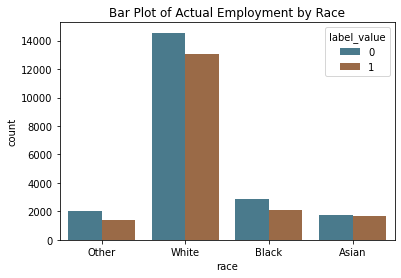

In [ ]:
#@title
label_by_race = sns.countplot(x="race", hue="label_value", data=pred_data, palette=aq_palette)
plt.title("Bar Plot of Actual Employment by Race");

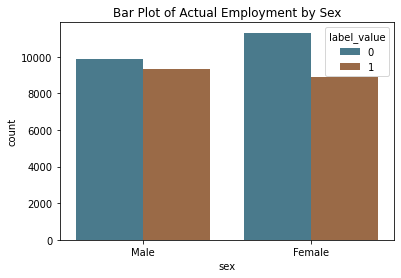

In [ ]:
#@title
label_by_sex = sns.countplot(x="sex", hue="label_value", data=pred_data, palette=aq_palette)
plt.title("Bar Plot of Actual Employment by Sex");

We start by plotting the predicted labels across race and sex. These already will show us where our models adds some bias.

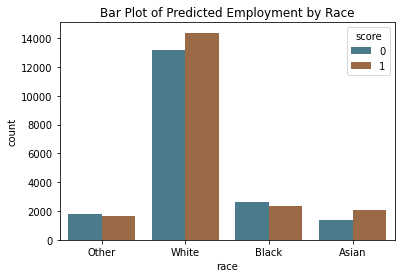

In [ ]:
#@markdown Inspect outcome by race

score_race = sns.countplot(x="race", hue="score", data=pred_data, palette=aq_palette)
plt.title("Bar Plot of Predicted Employment by Race");

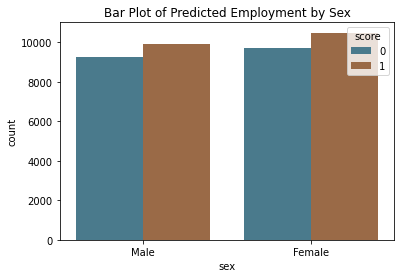

In [ ]:
#@title
score_sex = sns.countplot(x="sex", hue="score", data=pred_data, palette=aq_palette)
plt.title("Bar Plot of Predicted Employment by Sex");

#**TODO 2**: Interpret these plots. By race, which population are majority unemployed, but when predicted as majority employed? For sex, notice both men and women flip from majority unemployed to majority employed. What does this imply about our classifier across the board?

**Answer**:The first graph shows the true number of unemployed and unemployed people by race, the second graph shows the true number of unemployed and unemployed people in both groups of men and women, and the third graph shows the number of unemployed people by race Projected Unemployed and Not Unemployed, the fourth graph shows the projected number of unemployed and not unemployed in the two groups of men and women. In terms of race, the four ethnic groups are the majority of the unemployed, but when forecasting, only Other and Black are the majority of the unemployed. In terms of gender, both males and females are predicted to be employed, but the actual majority is unemployed, which shows that our model has a certain small threshold for judging employment/non-employment, resulting in the number of people predicted as 1 (employment) It has become more.

#**TODO 3:** Write some code to compare actual and predicted employment rates by all intersections of race and sex.

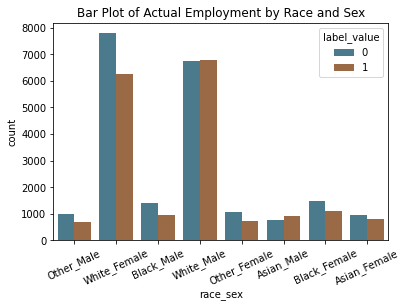

In [ ]:
#@title
# WRITE YOUR CODE HERE FOR ACTUAL EMPLOYMENT
# consider using plt.xticks(rotation = 25) to make the x-axis lables more legible
label_by_sex_race = sns.countplot(x="race_sex", hue="label_value", data=pred_data, palette=aq_palette)
plt.xticks(rotation = 25)
plt.title("Bar Plot of Actual Employment by Race and Sex");

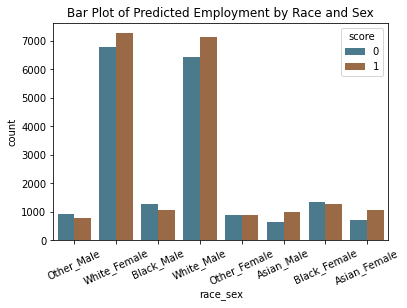

In [ ]:
#@title
# WRITE YOUR CODE HERE FOR PREDICTED EMPLOYMENT
label_by_sex_race = sns.countplot(x="race_sex", hue="score", data=pred_data, palette=aq_palette)
plt.xticks(rotation = 25)
plt.title("Bar Plot of Predicted Employment by Race and Sex");

#**TODO 4:** Note that most white people are unemployed and most men are unemployed, but most white men are employed. How is this possible?

**Answer**:This is possible. It may be that women are more unemployed among white people, and non-white people are more unemployed among men, which led to this situation.

## Using Aequitas

Practitioners need a way to decide if thse patterns reflect bias or not. The fact that there are many ways to detect bias makes this harder. To help with this, Aequitas provides a tool that reports a lot metrics all at once.


In [ ]:
#@title
g = Group()
xtab, _ = g.get_crosstabs(pred_data)

In [ ]:
#@markdown Get a sense of the predicted positives/negatives and confusion matrix
absolute_metrics = g.list_absolute_metrics(xtab)
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,0,binary 0/1,20434,race,Asian,2070,1347,581,205,1142,1489,1694,1723,3417,39394
1,0,binary 0/1,20434,race,Black,2328,2613,646,381,2232,1682,2063,2878,4941,39394
2,0,binary 0/1,20434,race,Other,1650,1801,466,228,1573,1184,1412,2039,3451,39394
3,0,binary 0/1,20434,race,White,14386,13199,3416,2058,11141,10970,13028,14557,27585,39394
4,0,binary 0/1,20434,sex,Female,10491,9698,3011,1401,8297,7480,8881,11308,20189,39394
5,0,binary 0/1,20434,sex,Male,9943,9262,2098,1471,7791,7845,9316,9889,19205,39394
6,0,binary 0/1,20434,race_sex,Asian_Female,1070,697,376,107,590,694,801,966,1767,39394
7,0,binary 0/1,20434,race_sex,Asian_Male,1000,650,205,98,552,795,893,757,1650,39394
8,0,binary 0/1,20434,race_sex,Black_Female,1272,1333,361,206,1127,911,1117,1488,2605,39394
9,0,binary 0/1,20434,race_sex,Black_Male,1056,1280,285,175,1105,771,946,1390,2336,39394


Aequitas uses some names and acronyms unlike what we have used in class:
- `precision` is PPV
- `ppr` $ = \frac{\text{PP}_G}{P}$ where $P$ is the total number of people predicted positive across all groups, and $\text{PP}_G$ is the number of people in group $G$ predicted positive.
- `pprev` is the Selection Rate
- `prev` is the Prevalence

In [ ]:
#@markdown View calculated "absolute metrics" (like false positive rates) for each group
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,race,Asian,0.88,0.66,0.15,0.28,0.34,0.12,0.85,0.72,0.10,0.61,0.50
1,race,Black,0.82,0.78,0.15,0.28,0.22,0.18,0.85,0.72,0.11,0.47,0.42
2,race,Other,0.84,0.77,0.13,0.28,0.23,0.16,0.87,0.72,0.08,0.48,0.41
3,race,White,0.84,0.77,0.16,0.24,0.23,0.16,0.84,0.76,0.70,0.52,0.47
4,sex,Female,0.84,0.73,0.14,0.29,0.27,0.16,0.86,0.71,0.51,0.52,0.44
5,sex,Male,0.84,0.79,0.16,0.21,0.21,0.16,0.84,0.79,0.49,0.52,0.49
6,race_sex,Asian_Female,0.87,0.61,0.15,0.35,0.39,0.13,0.85,0.65,0.05,0.61,0.45
7,race_sex,Asian_Male,0.89,0.73,0.15,0.20,0.27,0.11,0.85,0.80,0.05,0.61,0.54
8,race_sex,Black_Female,0.82,0.76,0.15,0.28,0.24,0.18,0.85,0.72,0.06,0.49,0.43
9,race_sex,Black_Male,0.82,0.79,0.14,0.27,0.21,0.18,0.86,0.73,0.05,0.45,0.40


## How do we understand biases in our model?

One of the major contributions of the Aequitas toolkit and enviornment is the `Fairness Tree`.

While a lot of bias metrics and fairness definitions have been proposed, there is no consensus on which definitions and metrics should be used in practice to evaluate and audit these systems. To help with this, the authors of Aequitas also created a guide for understanding when and what metrics might apply in a given situation, called the `Fairness Tree`. It can be found here: http://www.datasciencepublicpolicy.org/our-work/tools-guides/aequitas/



Consider the following scenario:

Suppose a certain country in Europe is building a model to predict the risk that a criminal is going to recidivate, similiar to the prediction made by the COMPAS model discussed in class.  However, in contrast to COMPAS, the goal is not to use these scores to determine whether or not an individual is allowed to be free; instead, almost all individuals with a high risk score will be admitted into a special program that has three components:  (1) the individuals recieve one-on-one counseling, (2) the individuals will recieve a monthly stipend, and (3) the individuals are set up with housing.  The program is a benefit to the individuals and is aimed at reducing recividism.

Think about the confusion matrix for the model.  How would you define the positive and negative class?

Suppose the country is trying to decide on the proper fairness metric to use for their machine learning model, and cares about the protected attribute race.  In terms of representation, they would either accept a model that has equal nominal representation of different races, or equal proportional representation in the special program.  They are also concerned about errors made by the model, and want to make sure that predictive equity among groups is acheieved for people with need.

Review the Aequitas guidelines for fairness metrics, and think about them in the context of this problem:  http://www.datasciencepublicpolicy.org/projects/aequitas/.


**Question:** Which of the following is NOT a good choice for a fairness metric for the model?

> a) False Negative Rate Parity \
> b) Equal Selection Parity \
> c) Demographic Parity \
> d) False Positive Rate Parity


#**TODO 5:** Justify your answer to the question above. Suppose the country wants to ensure that whether or not someone fails to get helped does not depend on their race. Which specific metric should they use then?

**Answer:** Choose B, because the Equal Selection Parity indicator is aimed at selecting the same number of people from different groups, and the number of white people in this data is significantly more than that of other races, so using this indicator cannot reflect fairness. Assuming the state wants to ensure that whether someone fails to get help does not depend on their race, Demographic Parity should be used.

## What is the scenario of our data?

In order to understand what metric (or metrics) we care about for the Folktables employment prediction, we need to know the full context of use, which isn't available. We will have to make one up: 
- Suppose the IRS is deciding who to audit. The training data for this tool was authentic random census data, but the test data entirely describes people who listed themselves as unemployed on their tax forms. People predicted to be employed are more likely to get audited.

Ideally, these audits should be distributed evenly across groups and not target one race in particular. These audits can be though of as a *punitive* intervention, because they may result in penalties, fines, or even jail time.

We could argue in favor of several different fairness metrics that are appropiate for this case: *Demographic Parity*, *False Discovery Rate Parity*, and *False Positive Rate Parity*. In this lab, we will use consider the last one (*FPR Parity*).

In [ ]:
#@markdown Write down the confusion matrix data again

xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,race,Asian,0.88,0.66,0.15,0.28,0.34,0.12,0.85,0.72,0.10,0.61,0.50
1,race,Black,0.82,0.78,0.15,0.28,0.22,0.18,0.85,0.72,0.11,0.47,0.42
2,race,Other,0.84,0.77,0.13,0.28,0.23,0.16,0.87,0.72,0.08,0.48,0.41
3,race,White,0.84,0.77,0.16,0.24,0.23,0.16,0.84,0.76,0.70,0.52,0.47
4,sex,Female,0.84,0.73,0.14,0.29,0.27,0.16,0.86,0.71,0.51,0.52,0.44
5,sex,Male,0.84,0.79,0.16,0.21,0.21,0.16,0.84,0.79,0.49,0.52,0.49
6,race_sex,Asian_Female,0.87,0.61,0.15,0.35,0.39,0.13,0.85,0.65,0.05,0.61,0.45
7,race_sex,Asian_Male,0.89,0.73,0.15,0.20,0.27,0.11,0.85,0.80,0.05,0.61,0.54
8,race_sex,Black_Female,0.82,0.76,0.15,0.28,0.24,0.18,0.85,0.72,0.06,0.49,0.43
9,race_sex,Black_Male,0.82,0.79,0.14,0.27,0.21,0.18,0.86,0.73,0.05,0.45,0.40


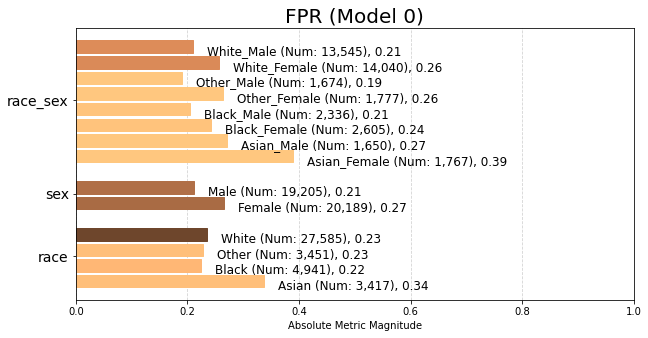

In [ ]:
#@markdown Plot the FPR within each group. The darker a bar is, the more people belong to that group.

aqp = Plot()
fnr = aqp.plot_group_metric(xtab, 'fpr')

# Note: if you have small group sizes, you can use the 'min_group_size' parameter:
# fnr = aqp.plot_group_metric(xtab, 'fnr', min_group_size=0.05)


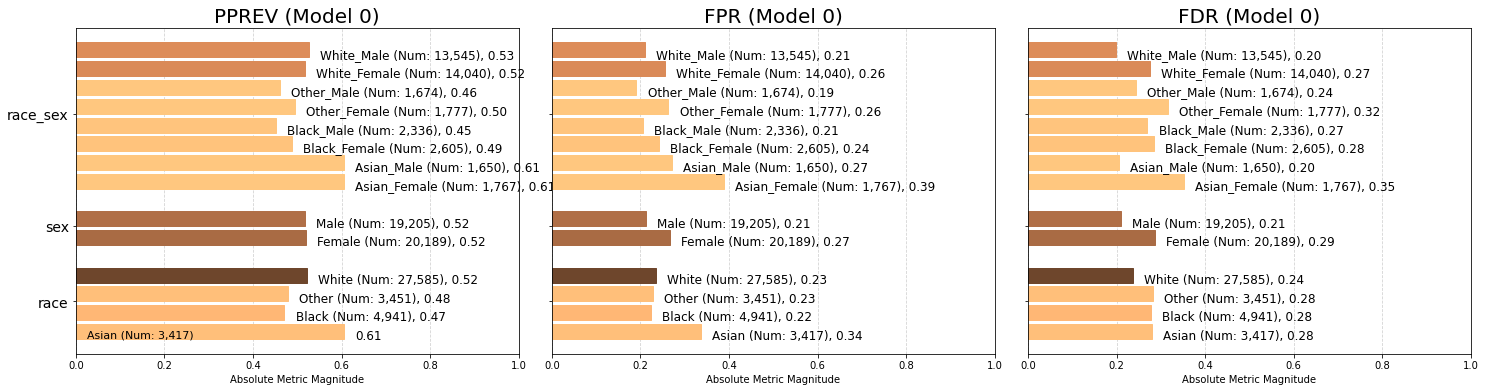

<Figure size 432x288 with 0 Axes>

In [ ]:
#@markdown We can look at all three metrics we discussed: Demographic Parity (pprev/selection rate), FDR, and FPR
p = aqp.plot_group_metric_all(xtab, metrics=['pprev','fpr','fdr'], ncols=3)

#**TODO 6:** Looking at the plot FPR here, we see that Asian women are the most discriminated against group by this model. Now look back at the bar plots between TODO 3 and TODO 4. Based on those bar plots, would you describe this bias against women as _Pre-Existing_ or _Technical_?

**Answer:** This bias should be innate, because no information such as gender is used during training, but a high FPR appears, indicating that the input data corresponding to Asian women is easier to predict a high value between 0 and 1 under the current model parameters. The score between (0 and 1 labels after thresholding), shows that this problem will occur when the data corresponding to Asianm women is trained together with other categories of data, which is an inherent problem.

#**TODO 7:**
What do we learn about the FPR on Asian men and Asian women that we cannot figure out by just looking at the FPR across race and gender individually?

**Answer:** There is not much difference between Asian men and other categories, but the FPR of Asian women is significantly higher than that of other categories, so it can be seen that the prejudice against Asian women is more serious, and a large part of the high FPR of Asian and Female categories may also be caused by Asian women contributed.

## Measuring bias with disparity

Typically, error-based metrics judge the fairness of a predictor by considering the *imbalance* between group-specific metrics. We can calculate imbalance as a difference --- mean, squared, absolute, etc. --- or as a **disparity** --- the ratio of a metric of one group, $g_j$, to that of a *reference group*, $g_{ref}$, usually chosen as the majority group:

$disparity_{g_j} = \frac{metric_{g_j}}{metric_{g_{ref}}}$

Generally, we require as a rule-of-thumb that $ 0.8 \leq disparity \leq 1.2$ (i.e. the metrics are within approx. 20% of each other).

Disparity ratios have been nice properties. For example, they are robust to small real values. Consider a model that has $fpr_1 = 0.002$ for one group and $fpr_2 = 0.04$ for the other. These values would satisfy a seemingly strict fairness constraint where $|fpr_1 - fpr_2| <= 0.05$, but this is likely not desirable to practitioners. Instead, using disparity ratios, this scenario would be considered unfair since $0.8 \nleq \frac{fpr_1}{fpr_2} \leq 1.2$.

In [ ]:
#@title
b = Bias()
bdf = b.get_disparity_predefined_groups(xtab, original_df=pred_data, ref_groups_dict={'race':'White', 'sex':'Male', 'race_sex': 'White_Male'}, alpha=0.05, mask_significance=True)

get_disparity_predefined_group()


In [ ]:
#@title
calculated_disparities = b.list_disparities(bdf)
bdf[['attribute_name', 'attribute_value'] +  ['fpr_disparity', 'pprev_disparity', 'fdr_disparity']]

# Look for disparity values outside of the bounds 0.8 <= disparity <= 1.2


,attribute_name,attribute_value,fpr_disparity,pprev_disparity,fdr_disparity
0,race,Asian,1.436961,1.161605,1.182029
1,race,Black,0.956524,0.903444,1.168616
2,race,Other,0.973919,0.916794,1.189390
3,race,White,1.000000,1.000000,1.000000
4,sex,Female,1.255081,1.003689,1.360210
5,sex,Male,1.000000,1.000000,1.000000
6,race_sex,Asian_Female,1.852491,1.152469,1.759977
7,race_sex,Asian_Male,1.288853,1.153448,1.026731
8,race_sex,Black_Female,1.154648,0.929312,1.421422
9,race_sex,Black_Male,0.975833,0.860346,1.351711


Notice The FPR disparity for race="Asian" is 1.44. That means that Asian folks in the dataset have an FPR 1.44x that of White folks.

We can also look at mosaic plots of the disparity. In these plots, the size of each block corresponds to the relative size of the population.

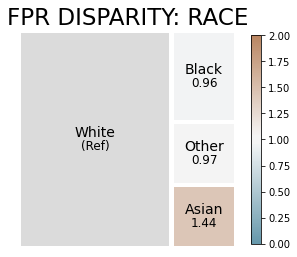

In [ ]:
#@title
aqp.plot_disparity(bdf, group_metric='fpr_disparity', attribute_name='race')

get_disparity_major_group()


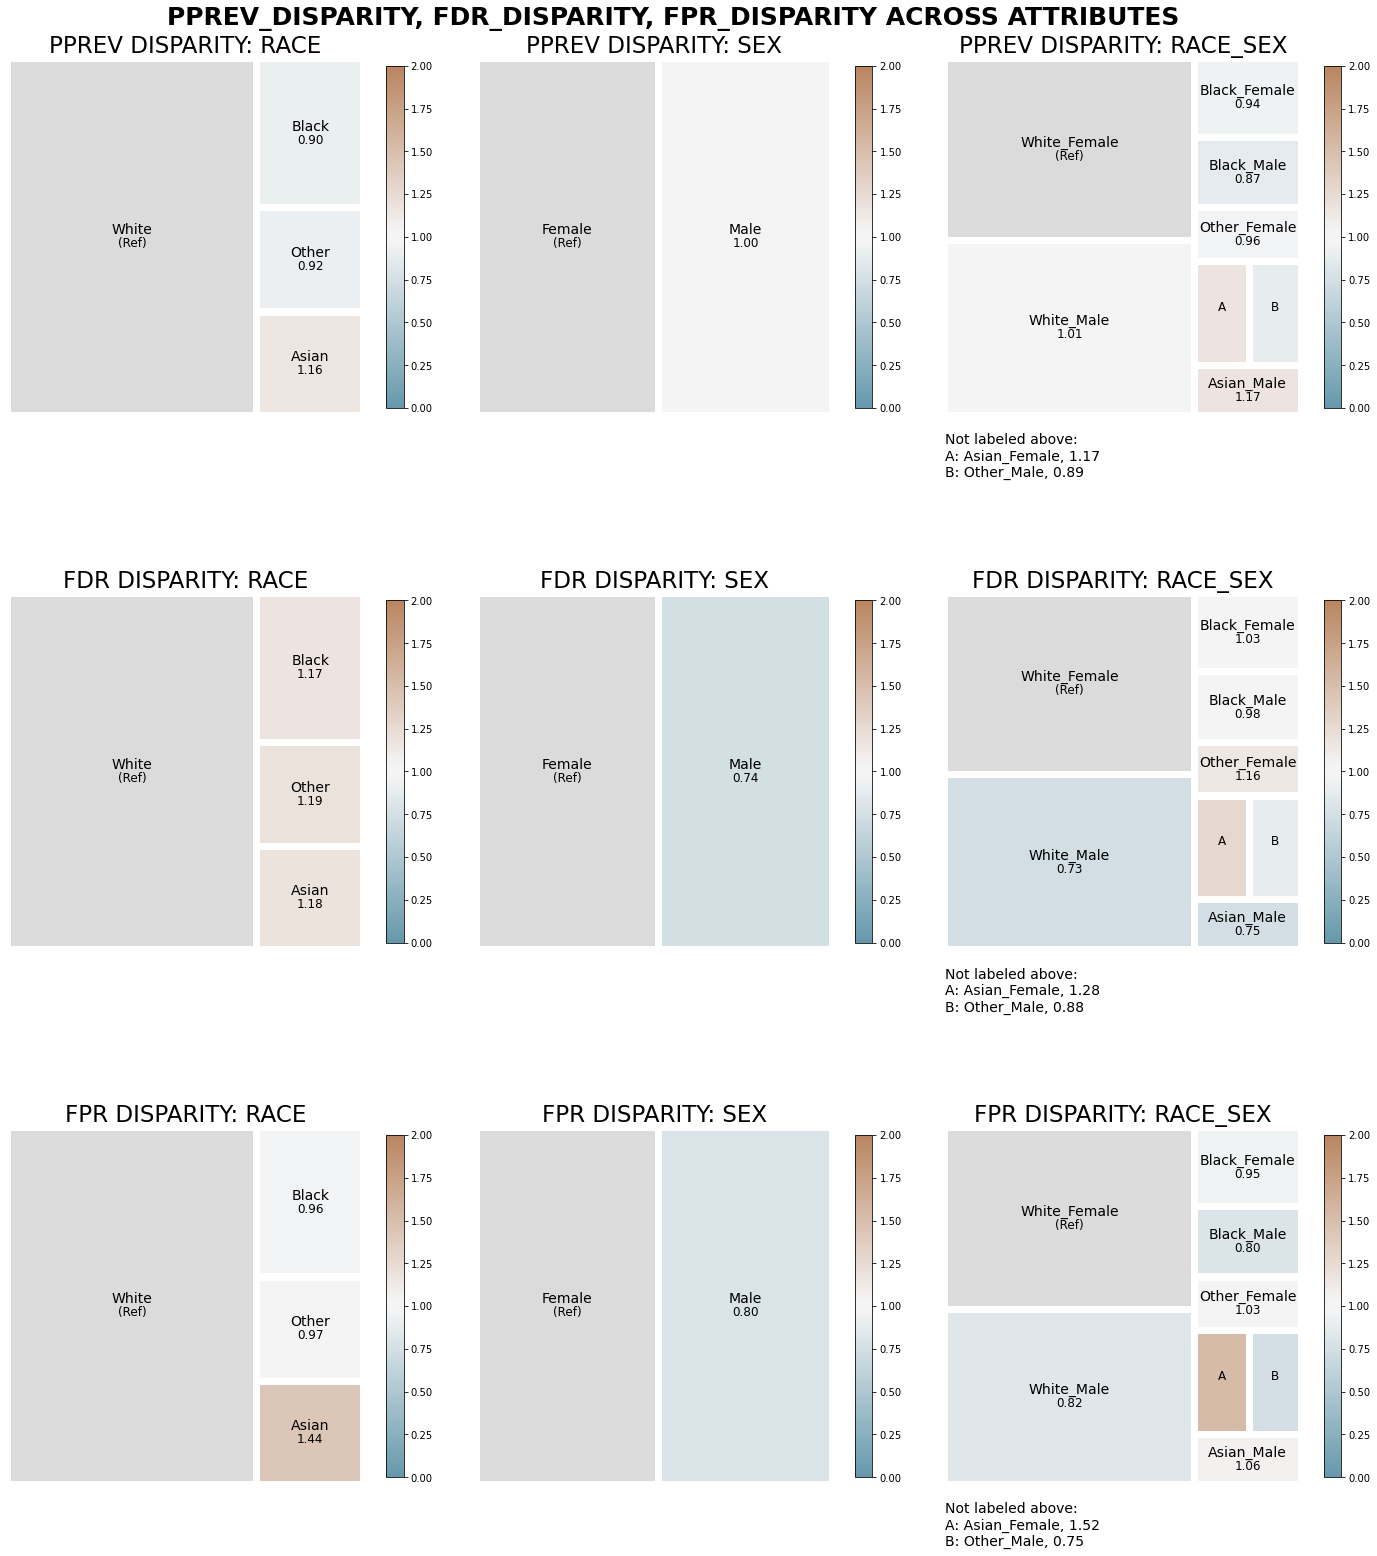

In [ ]:
#@title
majority_bdf = b.get_disparity_major_group(xtab, original_df=pred_data, mask_significance=True)
j = aqp.plot_disparity_all(majority_bdf, metrics=['pprev_disparity','fdr_disparity','fpr_disparity'], significance_alpha=0.05)

We can also apply statistical testing to see if disparities are significantly different from each other.

Those mosaics colored in green are those that have *Parity* between metrics at an $\alpha = 0.05$ significance level, and red indicates they have *disparity*.

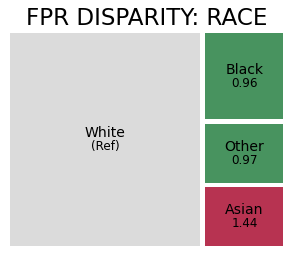

In [ ]:
#@title
f = Fairness()
fdf = f.get_group_value_fairness(bdf)
parity_detrminations = f.list_parities(fdf)
fdf[['attribute_name', 'attribute_value'] + absolute_metrics + calculated_disparities + parity_detrminations].style
m = aqp.plot_fairness_disparity(fdf, group_metric='fpr', attribute_name='race')

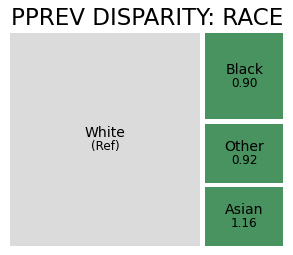

In [ ]:
#@title
m = aqp.plot_fairness_disparity(fdf, group_metric='pprev', attribute_name='race')

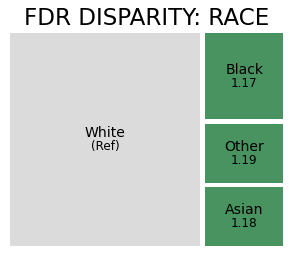

In [ ]:
#@title
m = aqp.plot_fairness_disparity(fdf, group_metric='fdr', attribute_name='race')

For this model, it seems like our biggest issue is a FPR disparity for Asain folks as compared to White folks.

If we took this tutorial one step further an applied bias mitigation, this would be an appropiate target.

#**TODO 8:** Write some code to test for statistical disparity across race and sex intersectionally.

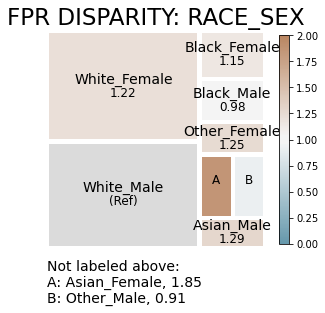

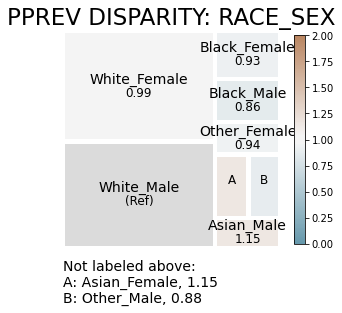

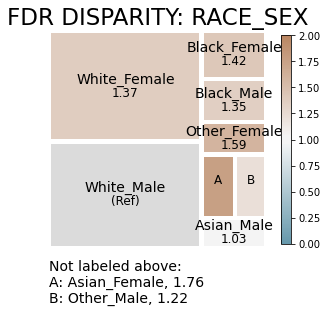

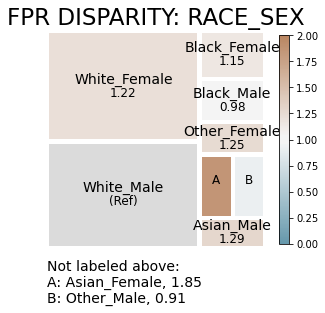

In [ ]:
#@title
## YOUR CODE HERE
aqp.plot_disparity(bdf, group_metric='fpr_disparity', attribute_name='race_sex')
aqp.plot_disparity(bdf, group_metric='pprev_disparity', attribute_name='race_sex')
aqp.plot_disparity(bdf, group_metric='fdr_disparity', attribute_name='race_sex')
aqp.plot_disparity(bdf, group_metric='fpr_disparity', attribute_name='race_sex')